# Basic Tutorial: `GaussNoiseModel`

Trey V. Wenger (c) March 2025

This notebook is nearly identical to the basic tutorial, except we implement a new model called `GaussNoiseModel`. This model allows the spectral rms to be an inferred parameter. Such is a useful trick for complicated posterior distributions, such as when there are multiple, high signal-to-noise components.

In [1]:
# General imports    
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np

print("arviz version:", az.__version__)

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

arviz version: 0.22.0dev
pymc version: 5.22.0
bayes_spec version: 1.7.9-staging+2.gb86248c.dirty


## Data Format

In [2]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

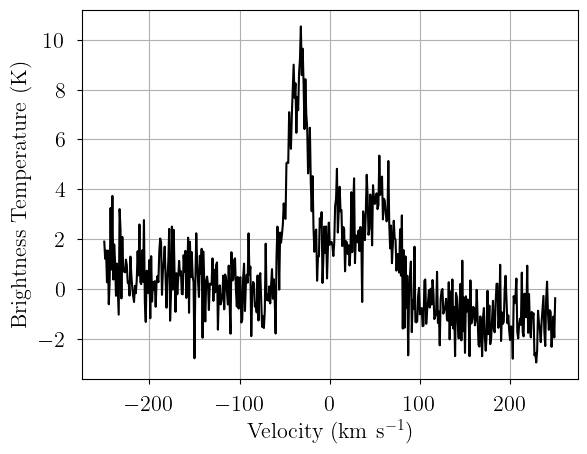

In [3]:
from bayes_spec.models import GaussNoiseModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = GaussNoiseModel(dummy_data, n_clouds=n_clouds, baseline_degree=baseline_degree, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

sim_params = {
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "rms_observation": noise, # spectral rms (K)
    "baseline_observation_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observation
sim_brightness = model.model.observation.eval(sim_params, on_unused_input="ignore")

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model

In [5]:
model = GaussNoiseModel(data, n_clouds=n_clouds, baseline_degree=baseline_degree, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

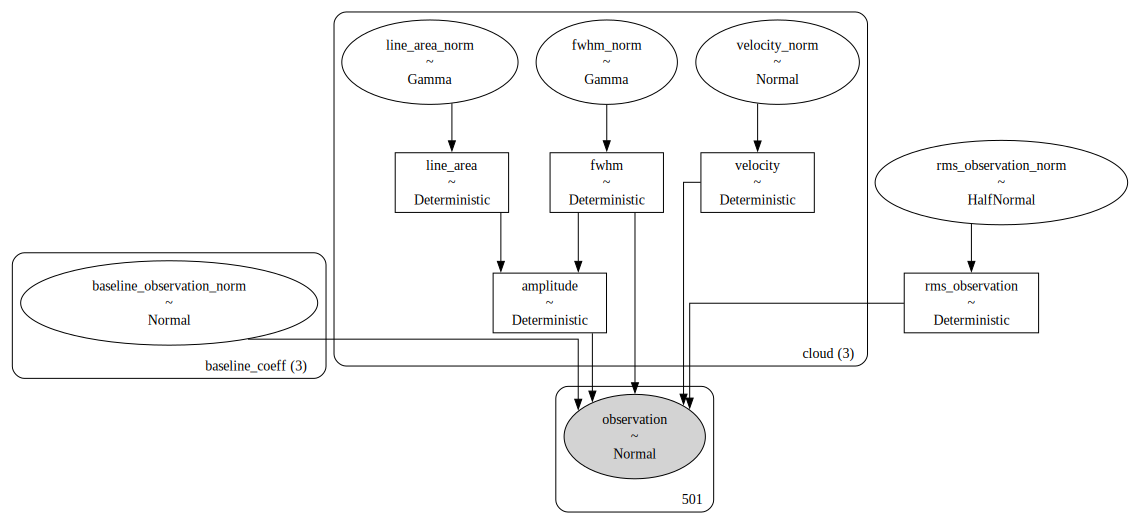

In [6]:
# Plot model graph
model.graph()

Sampling: [baseline_observation_norm, fwhm_norm, line_area_norm, observation, rms_observation_norm, velocity_norm]


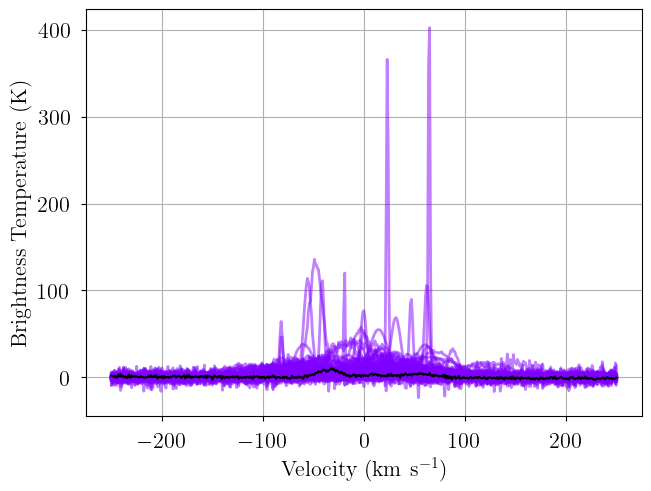

In [7]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

baseline_freeRVs ['baseline_observation_norm']
baseline_deterministics []
cloud_freeRVs ['line_area_norm', 'fwhm_norm', 'velocity_norm']
cloud_deterministics ['line_area', 'fwhm', 'velocity', 'amplitude']
hyper_freeRVs ['rms_observation_norm']
hyper_deterministics ['rms_observation']


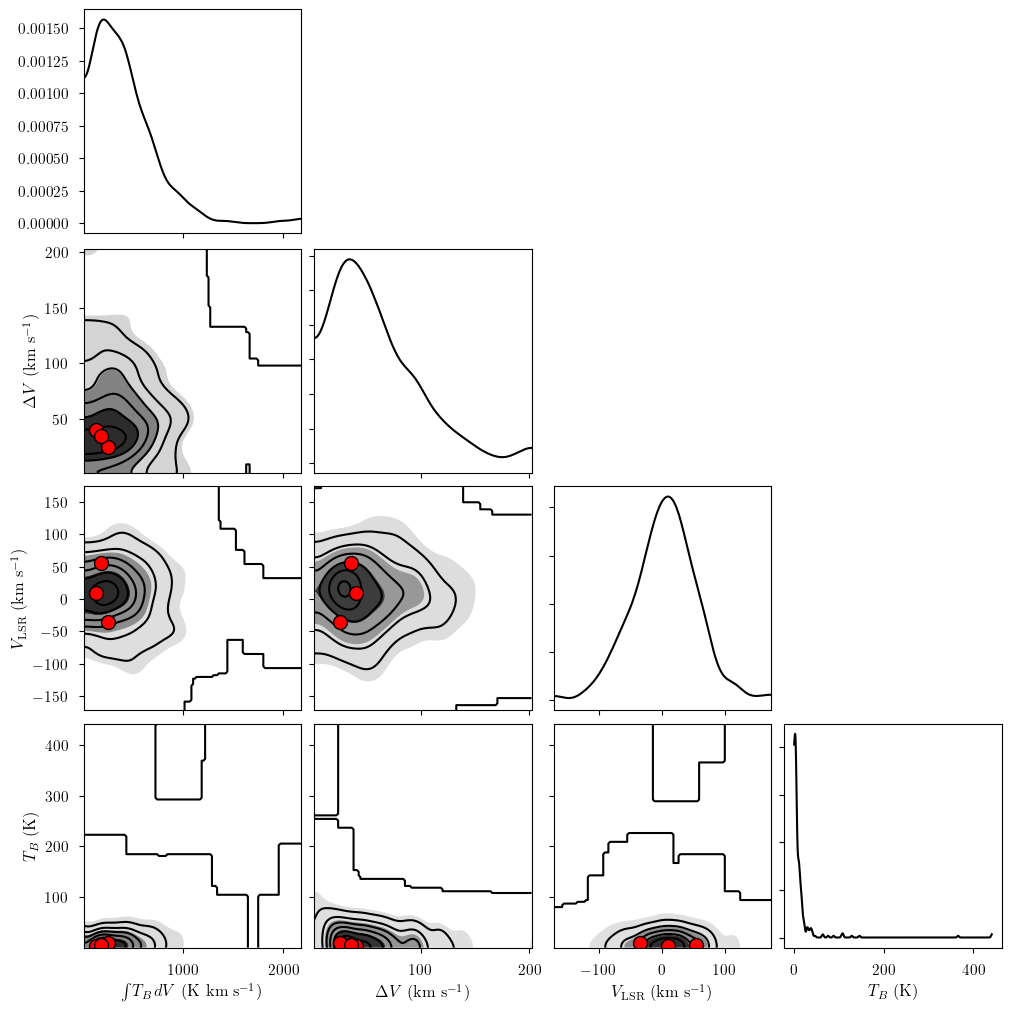

In [8]:
from bayes_spec.plots import plot_pair

# available parameter attributes:
print("baseline_freeRVs", model.baseline_freeRVs)
print("baseline_deterministics", model.baseline_deterministics)
print("cloud_freeRVs", model.cloud_freeRVs)
print("cloud_deterministics", model.cloud_deterministics)
print("hyper_freeRVs", model.hyper_freeRVs)
print("hyper_deterministics", model.hyper_deterministics)

_ = plot_pair(
    prior.prior, # samples
    model.cloud_deterministics, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

## Posterior Sampling: MCMC

In [9]:
init_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.01,
    "learning_rate": 0.001,
    "start": {"velocity_norm": np.linspace(-3.0, 3.0, n_clouds)},
}
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = init_kwargs, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 21700
Interrupted at 21,699 [2%]: Average Loss = 1,083.4
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


Adding log-likelihood to trace


Output()

There were 9 divergences in converged chains.


In [10]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [0 2 1]
Chain 1 order: [0 2 1]
Chain 2 order: [0 2 1]
Chain 3 order: [0 2 1]
Chain 4 order: [0 2 1]
Chain 5 order: [0 2 1]
Chain 6 order: [1 2 0]
Chain 7 order: [0 2 1]
Adopting (first) most common order: [0 2 1]


In [11]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_observation_norm[0],-0.343,0.072,-0.481,-0.210,0.001,0.001,4263.0,4406.0,1.00
baseline_observation_norm[1],-2.156,0.150,-2.435,-1.875,0.002,0.002,7836.0,5078.0,1.00
baseline_observation_norm[2],0.687,0.893,-1.036,2.323,0.013,0.010,4704.0,4776.0,1.00
velocity_norm[0],0.209,0.066,0.100,0.338,0.002,0.002,2140.0,1421.0,1.01
velocity_norm[1],-0.690,0.010,-0.709,-0.671,0.000,0.000,3035.0,3553.0,1.00
velocity_norm[2],1.102,0.042,1.027,1.188,0.001,0.001,1726.0,1924.0,1.00
line_area_norm[0],0.564,0.162,0.305,0.875,0.005,0.006,1451.0,1138.0,1.01
line_area_norm[1],1.244,0.064,1.119,1.360,0.002,0.001,1868.0,1583.0,1.00
line_area_norm[2],0.859,0.132,0.601,1.099,0.004,0.004,1442.0,1018.0,1.00
fwhm_norm[0],1.230,0.392,0.686,2.028,0.012,0.014,1455.0,1140.0,1.01


Sampling: [observation]


Output()

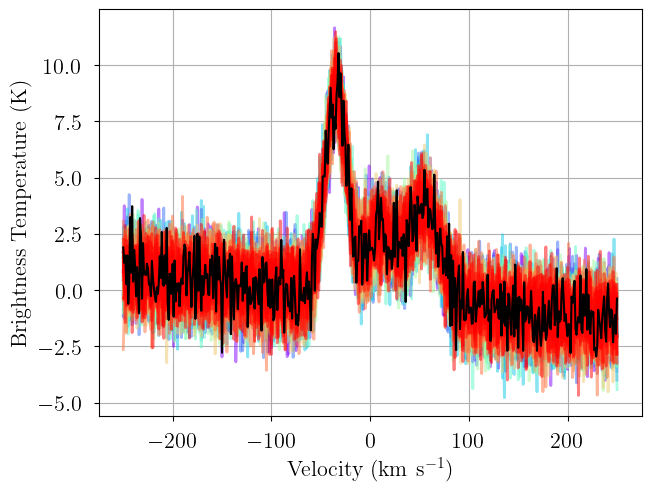

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

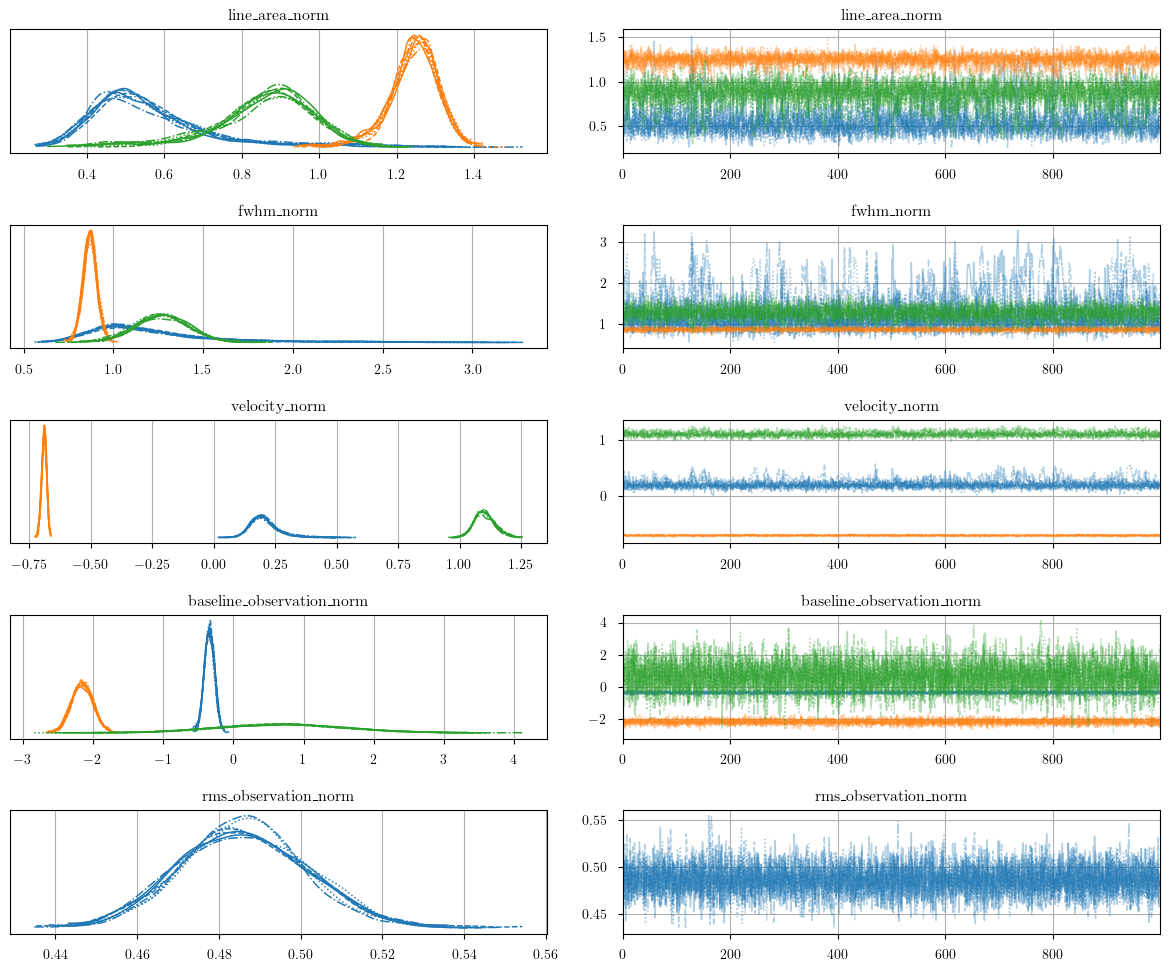

In [13]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

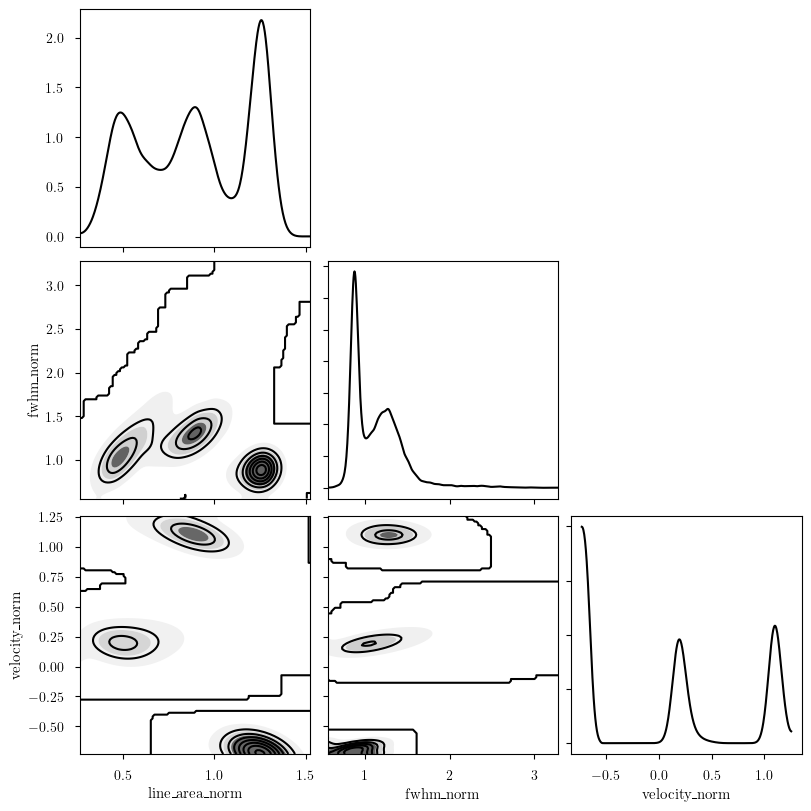

In [14]:
_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

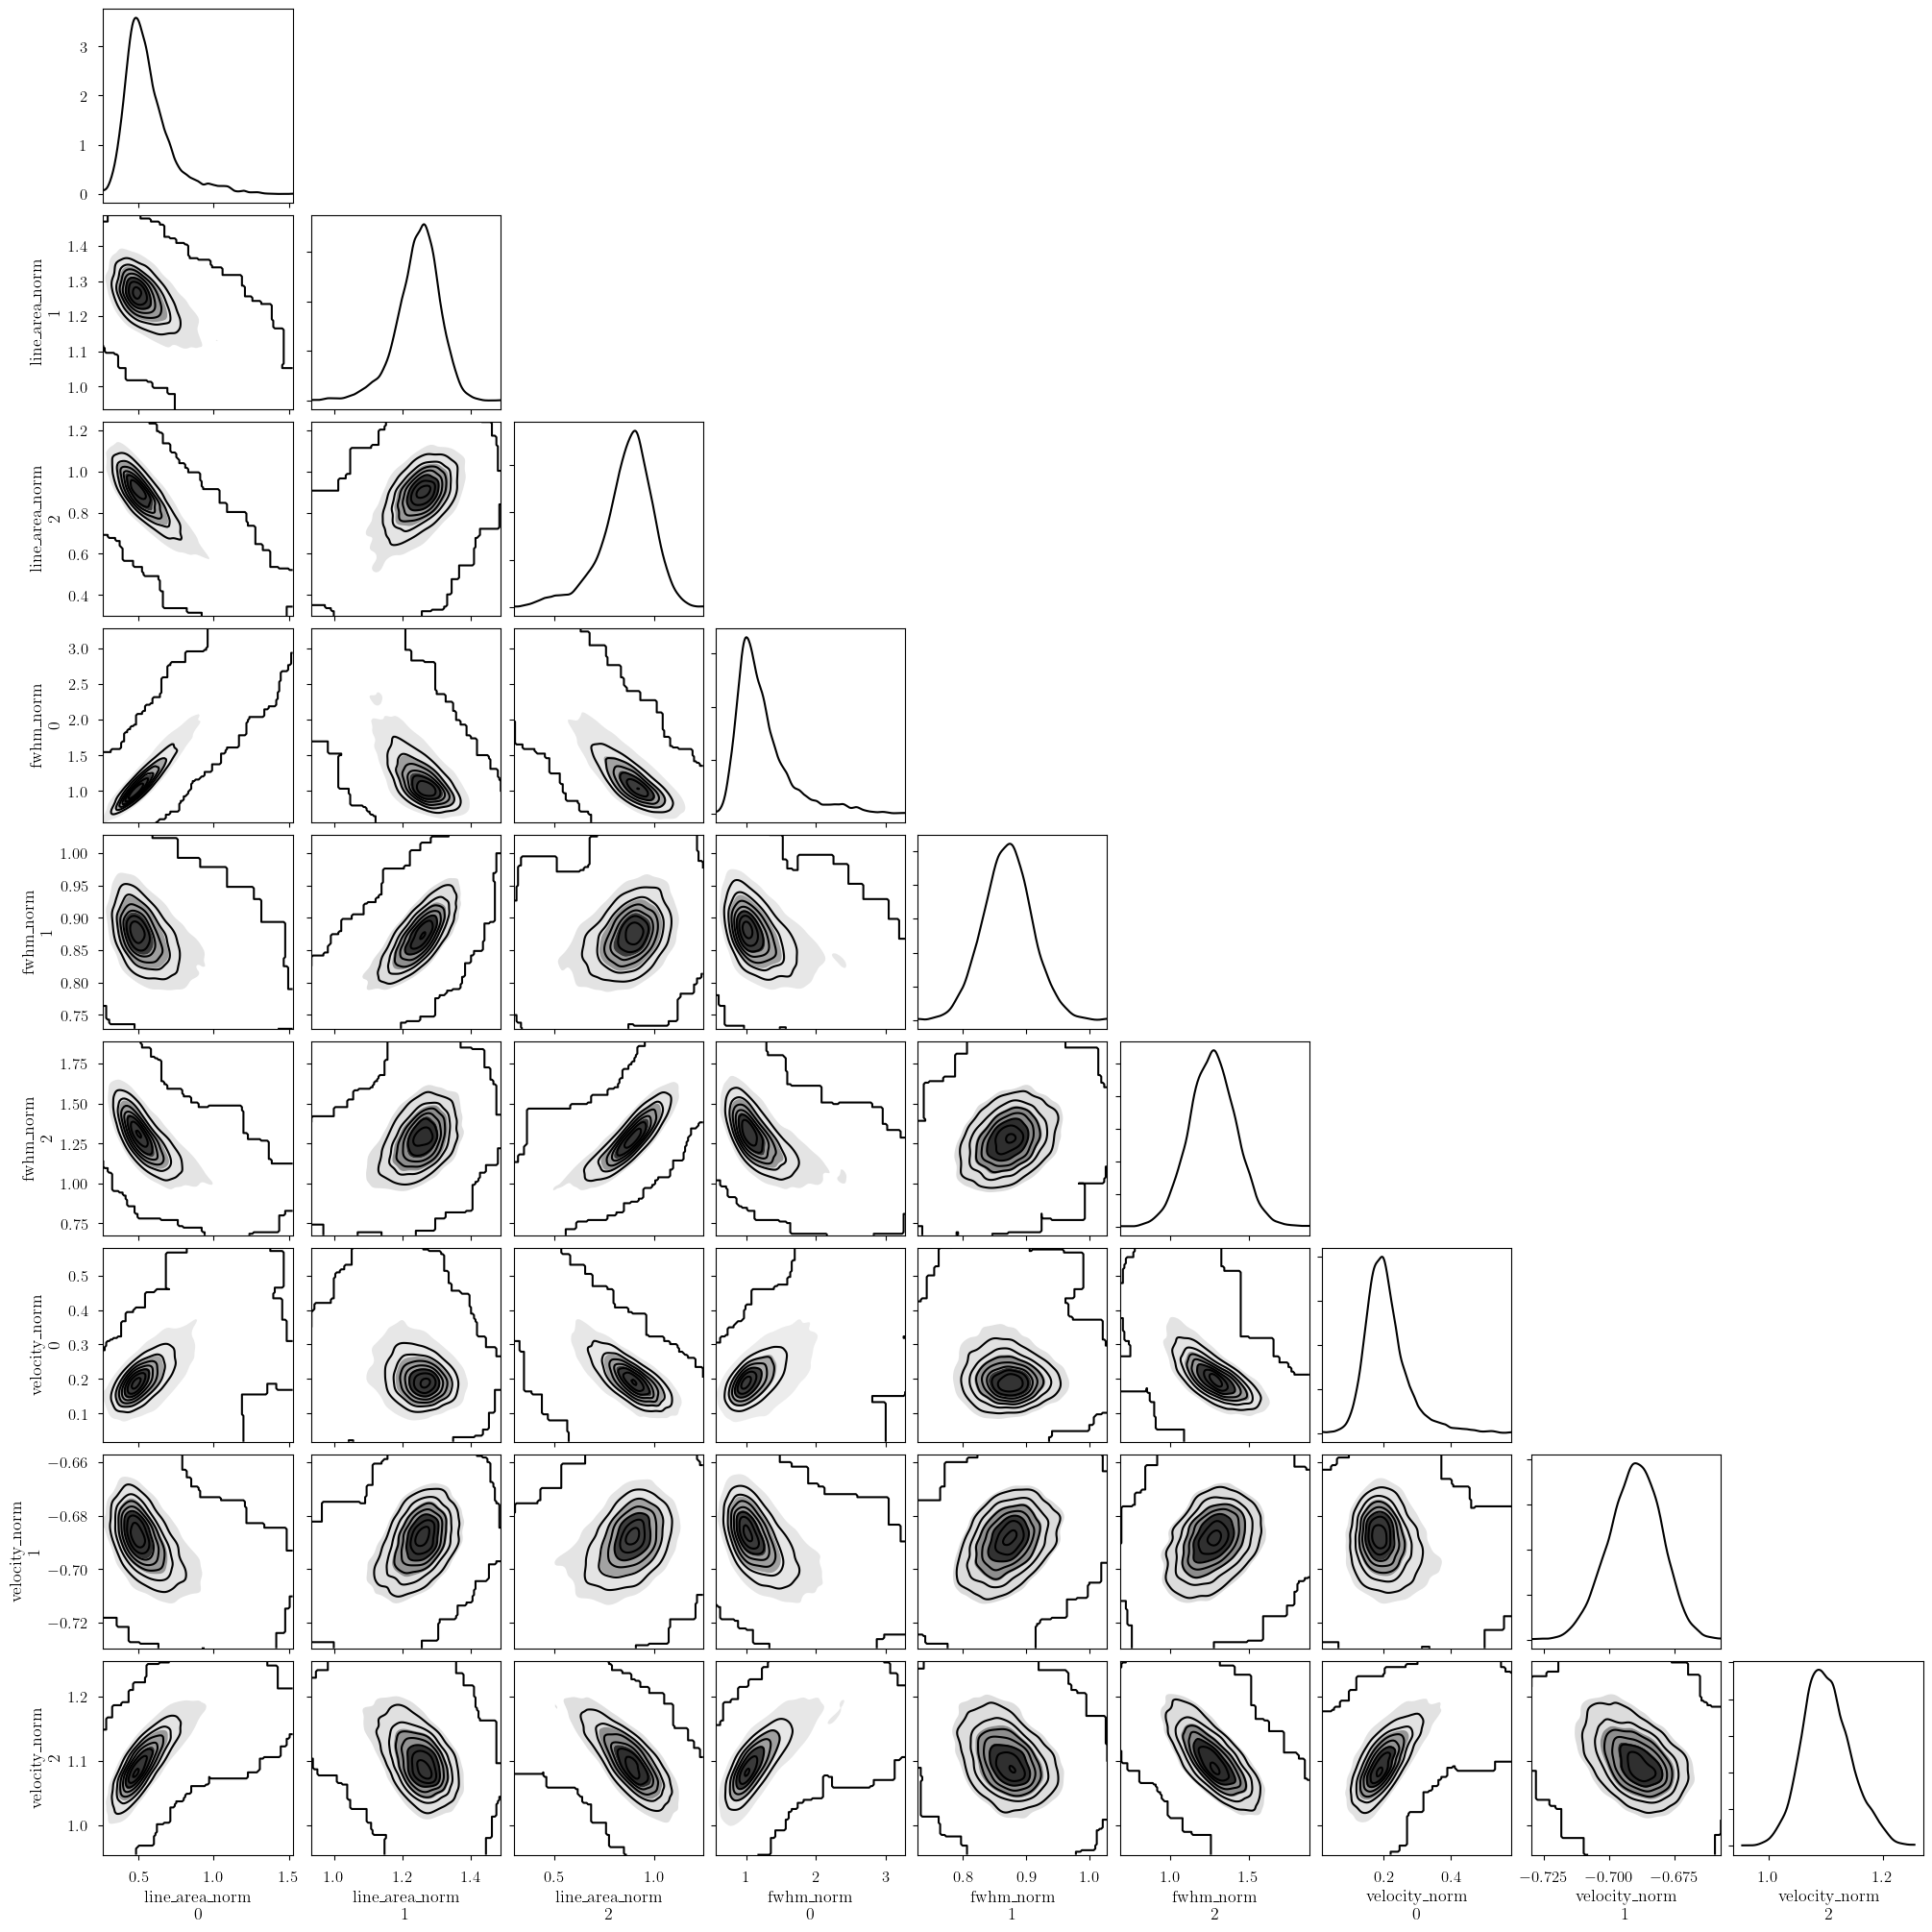

In [15]:
_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    combine_dims=None, # do not concatenate clouds
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

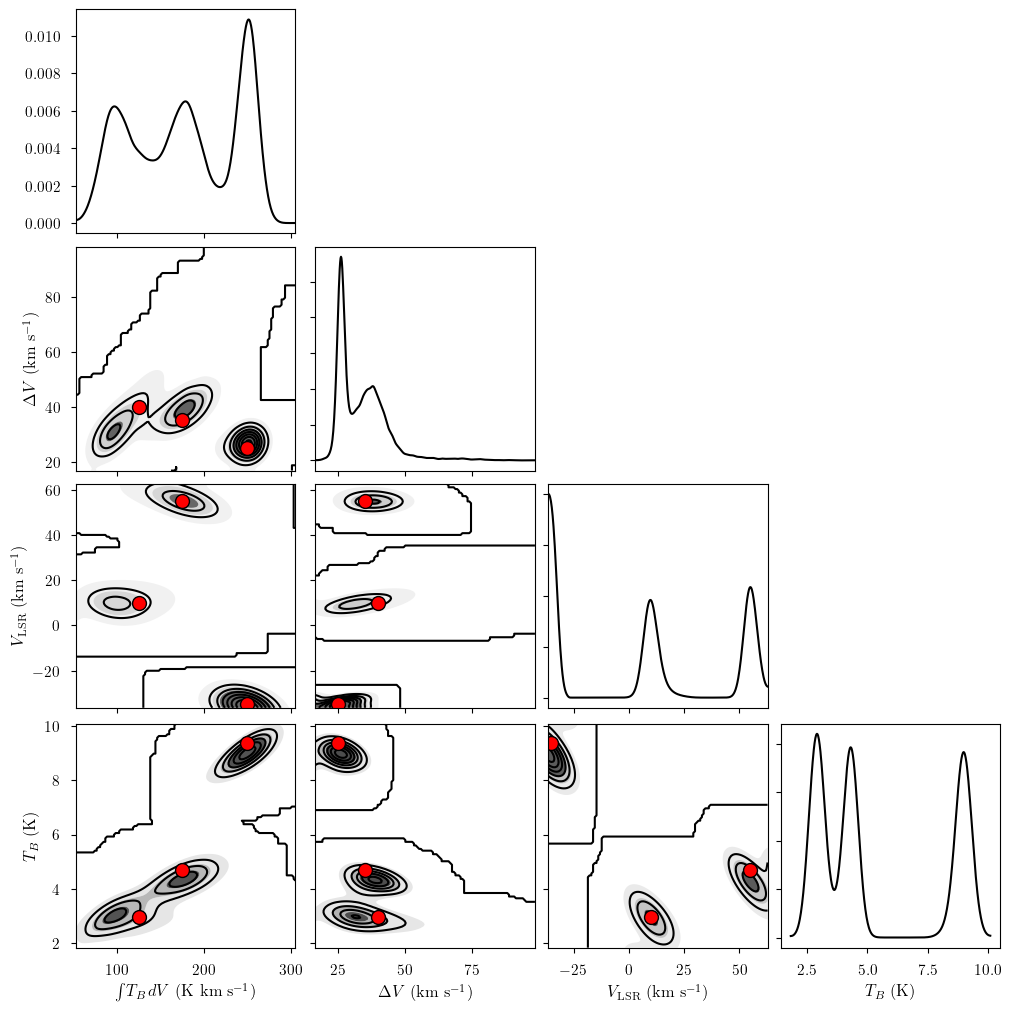

In [16]:
_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_deterministics, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

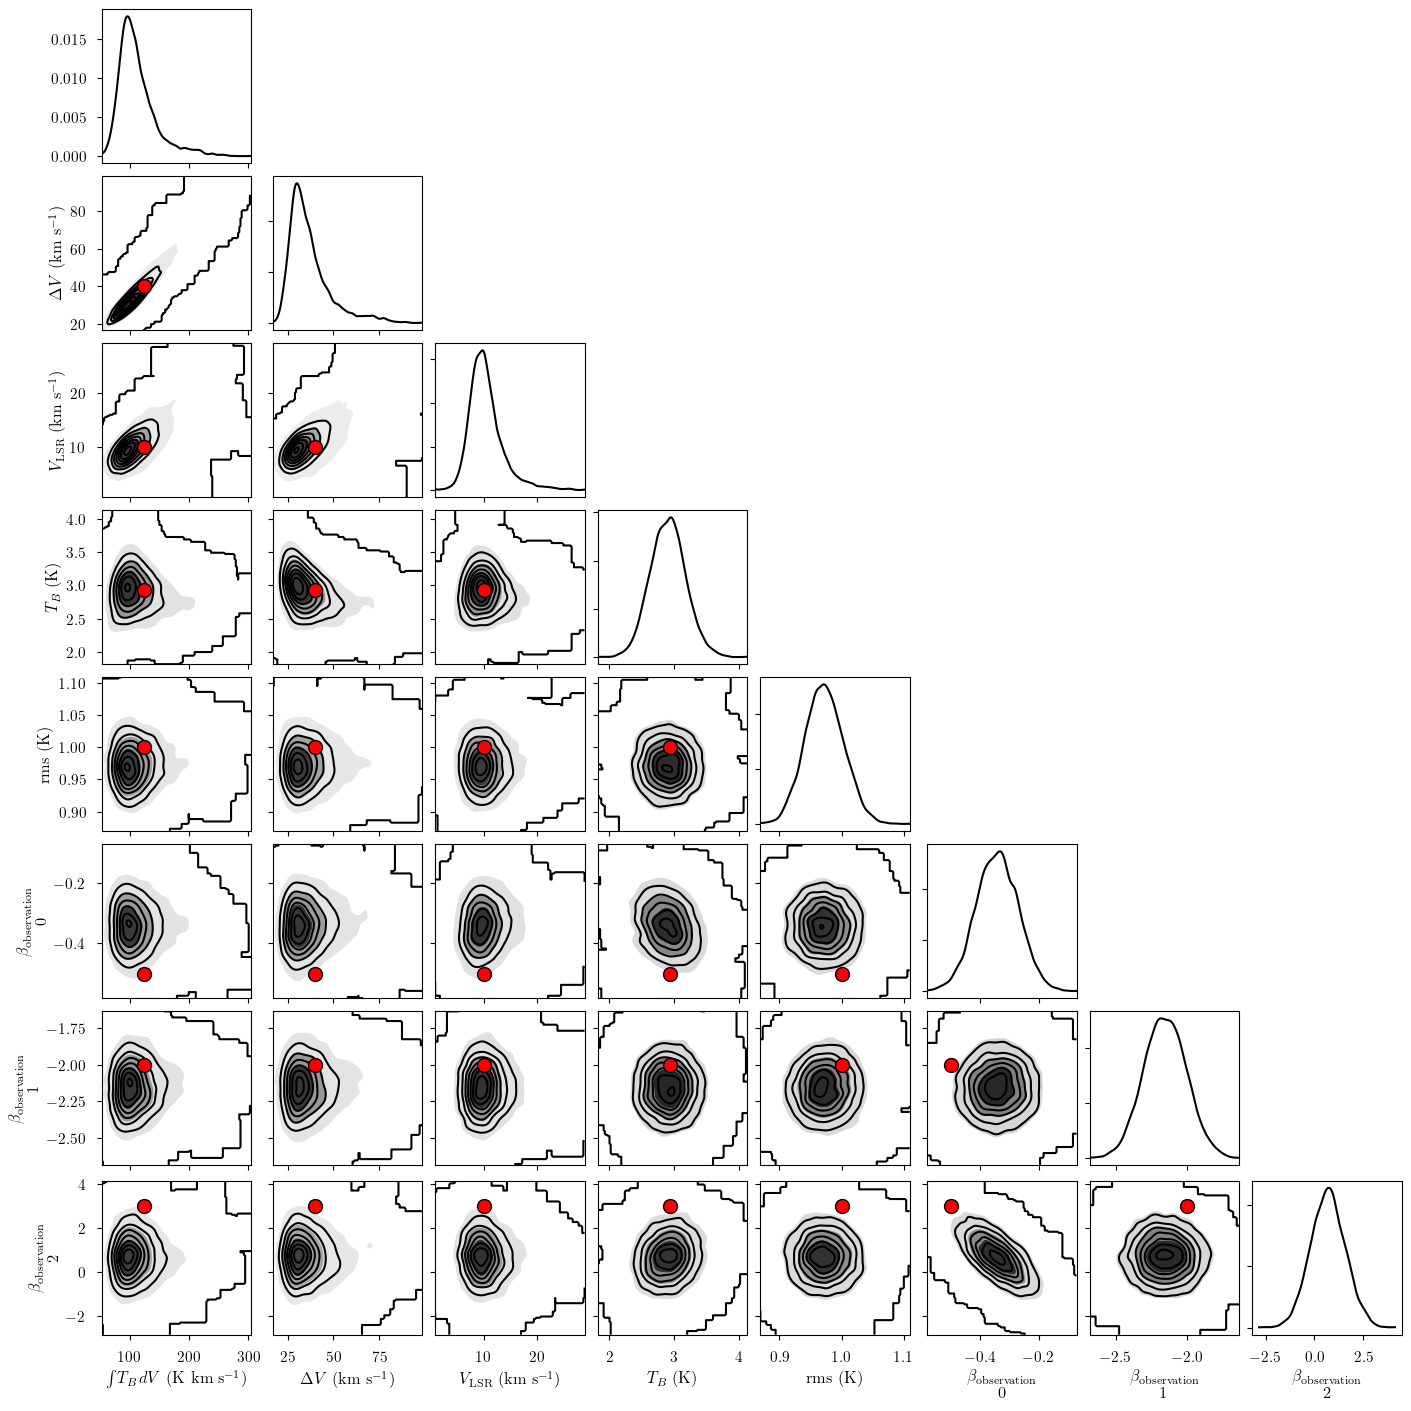

In [17]:
my_true_cloud = 1
my_sim_params = {}
for var_name in model.cloud_deterministics:
    my_sim_params[var_name] = sim_params[var_name][my_true_cloud]
for var_name in model.hyper_deterministics:
    my_sim_params[var_name] = sim_params[var_name]
for var_name in model.baseline_freeRVs:
    my_sim_params[var_name] = sim_params[var_name]
    
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics + model.hyper_deterministics + model.baseline_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=my_sim_params, # truths
)

In [18]:
point_stats = az.summary(model.trace.solution_0, var_names=model.cloud_deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
point_stats

BIC: 1472.7388320637951


,mean,sd,hdi_16%,hdi_84%
line_area[0],112.818,32.331,79.906,127.432
line_area[1],248.877,12.778,238.009,260.860
line_area[2],171.892,26.343,154.299,199.374
fwhm[0],36.907,11.750,24.403,40.431
fwhm[1],26.105,1.160,25.021,27.279
fwhm[2],38.140,4.506,33.589,42.357
velocity[0],10.462,3.286,6.990,12.056
velocity[1],-34.503,0.501,-34.945,-33.956
velocity[2],55.092,2.111,52.822,56.883
amplitude[0],2.904,0.274,2.630,3.167
